# Question 1

## Loading Dataset

Mounting the drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Downloading the dataset from the link provided in CA description:

In [ ]:
import requests
import os

# Create a directory to save the dataset
if not os.path.exists('/content/drive/MyDrive/NN_CA3/brain_tumor_dataset'):
    os.makedirs('/content/drive/MyDrive/NN_CA3/brain_tumor_dataset')

# Download and save the dataset
url = 'https://figshare.com/ndownloader/articles/1512427/versions/5'
response = requests.get(url)
with open('/content/drive/MyDrive/NN_CA3/brain_tumor_dataset/brain_tumor_dataset.zip', 'wb') as f:
    f.write(response.content)

Unziping the downloaded file:

In [ ]:
Expand-Archive -Path /1512427.zip -DestinationPath /brain_tumor_zipFiles/

Unzip all files and save all images in brain_tumor_images folder:

In [ ]:
import zipfile
import os

source_dir = '/content/drive/MyDrive/NN_CA3/brain_tumor_zipFiles/'
target_dir = '/content/drive/MyDrive/NN_CA3/brain_tumor_images/'

for file_name in os.listdir(source_dir):
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(os.path.join(source_dir, file_name), 'r') as zip_ref:
            zip_ref.extractall(target_dir)

Check if all images are extracted and exist in brain_tumor_images folder:

In [ ]:
import os

expected_num_files = 3064

num_files = len(os.listdir(target_dir))

if num_files == expected_num_files:
    print("Extraction successful!")
else:
    print("Extraction failed. Number of files extracted:", num_files)

Deleting zip files:

In [ ]:
import shutil

directory = "/content/drive/MyDrive/NN_CA3/brain_tumor_zipFiles/"

shutil.rmtree(directory)

## Preprocessing

Showing .mat files details:

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io
import matplotlib.pyplot as plt
import h5py
import random

def show_files_details():
  folder_path = 'images/'

  img_files = os.listdir(folder_path)

  # Select a random image file
  rand_img = random.choice(img_files)
  img_path = os.path.join(folder_path, rand_img)
  mat_file = h5py.File(img_path, 'r')
  print(type(mat_file))
  print(mat_file.keys())
  print(mat_file['cjdata'].keys())
  print(mat_file['cjdata']['PID'][()])
  print(mat_file['cjdata']['image'][()])
  print(mat_file['cjdata']['label'][()])
  print(type(mat_file['cjdata']['image'][()]))
  print(mat_file['cjdata']['image'][()].shape)

show_files_details()

<class 'h5py._hl.files.File'>
<KeysViewHDF5 ['cjdata']>
<KeysViewHDF5 ['PID', 'image', 'label', 'tumorBorder', 'tumorMask']>
[[49]
 [48]
 [57]
 [52]
 [55]
 [49]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 3 8 ... 7 4 4]
 [2 2 7 ... 6 5 5]
 [3 2 7 ... 6 5 6]]
[[3.]]
<class 'numpy.ndarray'>
(512, 512)


Showing some images from dataset:

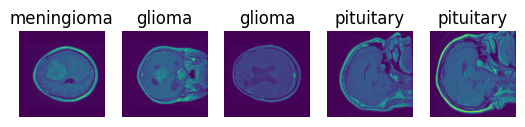

In [ ]:
def show_image_samples():
  folder_path = 'images/'
  img_files = os.listdir(folder_path)
  for i in range(5):
      rand_img = random.choice(img_files)
      img_path = os.path.join(folder_path, rand_img)
      mat_file = h5py.File(img_path, 'r')
      image_data = mat_file['cjdata']['image'][()]
      plt.subplot(1, 5, i+1)
      plt.imshow(image_data)
      plt.axis('off')
      if mat_file['cjdata']['label'][()][0][0] == 1:
        plt.title('meningioma')
      elif mat_file['cjdata']['label'][()][0][0] == 2:
        plt.title('glioma')
      else:
        plt.title('pituitary')
      mat_file.close()
      
  plt.show()

show_image_samples()

Extracting images data and labels from files and save them in x (images data) and y (images labels) variables:

In [ ]:
import numpy as np
from PIL import Image
from skimage import transform


image_counts = 3064
x_data = np.zeros((image_counts, 256, 256, 3))
y_data = np.zeros((image_counts, 1))

folder_path = 'images/'
img_files = os.listdir(folder_path)

for index, img_file in enumerate(img_files):
  img_path = os.path.join(folder_path, img_file)
  mat_file = h5py.File(img_path, 'r')
  image_arr = transform.resize(mat_file['cjdata']['image'][()], (256, 256))
  image_arr = np.stack((image_arr,)*3, axis=-1)
  x_data[index] = image_arr
  y_data[index] = mat_file['cjdata']['label'][()][0][0]
  del image_arr
  mat_file.close()

In [ ]:
print(f"Size in bytes: {x_data.nbytes}")
print(f"Size in megabytes: {x_data.nbytes / 1024 / 1024}")

Size in bytes: 4819255296
Size in megabytes: 4596.0


In [ ]:
x_data.shape

(3064, 256, 256, 3)

Checking if data is ready and correct:

In [ ]:
print(x_data.shape)
print(y_data.shape)
print(y_data[0])

(3064, 256, 256, 3)
(3064, 1)
[1.]


Because we have three classes, we need to use OneHotEncoder to convert 1, 2, 3 into a binary representation (for example the classes will be 100, 010 and 001) and save it in a 2D array:

In [ ]:
from sklearn.preprocessing import OneHotEncoder 
  
onehotencoder = OneHotEncoder() 
y_data = onehotencoder.fit_transform(y_data).toarray() 
print(y_data.shape,x_data.shape)
print(y_data[0])

(3064, 3) (3064, 256, 256, 3)
[1. 0. 0.]


## Creating The Model

Importing required libraries:

In [ ]:
import keras
from keras import optimizers
from keras import regularizers
from keras import applications
from keras import backend as k 
from sklearn.model_selection import KFold
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

2023-05-05 00:19:17.536326: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dividing a dataset into K number of subsets or "folds". The model is then trained on K-1 folds and tested on the remaining fold. This process is repeated K times, with each fold being used as the testing set once.
Here we also set batch size and number of epochs:

In [ ]:
imageWidth = 256
imageHeight = 256

batch_size = 50
epochs = 5

Loading the model. Here we are using transfer learning so we use other models in our model:

In [ ]:
model = applications.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (imageWidth, imageHeight, 3))

Here we add our Cusom layers and create the final model:

In [ ]:
from keras.layers import Dense, LeakyReLU, Dropout
from keras import regularizers

for layer in model.layers:
    layer.trainable = False

x=Flatten()(model.output)

x = Dense(2048)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.2)(x)
x = Dense(2048)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.2)(x)
x = Dense(1024)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.2)(x)


predictions = Dense(3, activation="softmax",name='output')(x)

model_final = Model(inputs=model.input,outputs=predictions)
adamopt=optimizers.Adam(0.0001)

model_final.compile(loss=keras.losses.categorical_crossentropy, optimizer=adamopt, metrics=["accuracy"])
# model_final.summary()

## Training The Model

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=42,shuffle=True)

del x_data
del y_data

In [ ]:
kf = KFold(n_splits=5,random_state=None, shuffle=True)
kf.get_n_splits(x_train)

5

In [ ]:
history_list = []
i=0;
for train_index, test_index in kf.split(x_train):

    print(i);
    history = model_final.fit( x_train[train_index], y_train[train_index], batch_size=50, epochs=5,validation_data=(x_train[test_index],y_train[test_index]))
    history_list.append(history)
    i=i+1;

0
Epoch 1/5
37/37 [==============================] - 150s 4s/step - loss: 1.3109 - accuracy: 0.6768 - val_loss: 0.5425 - val_accuracy: 0.7717
Epoch 2/5
37/37 [==============================] - 141s 4s/step - loss: 0.4794 - accuracy: 0.8264 - val_loss: 0.3589 - val_accuracy: 0.8652
Epoch 3/5
37/37 [==============================] - 142s 4s/step - loss: 0.5243 - accuracy: 0.8183 - val_loss: 0.5425 - val_accuracy: 0.8065
Epoch 4/5
37/37 [==============================] - 142s 4s/step - loss: 0.2993 - accuracy: 0.8999 - val_loss: 0.4082 - val_accuracy: 0.8370
Epoch 5/5
37/37 [==============================] - 142s 4s/step - loss: 0.2680 - accuracy: 0.9108 - val_loss: 0.3828 - val_accuracy: 0.8717
1
Epoch 1/5
37/37 [==============================] - 143s 4s/step - loss: 0.1923 - accuracy: 0.9282 - val_loss: 0.1158 - val_accuracy: 0.9522
Epoch 2/5
37/37 [==============================] - 141s 4s/step - loss: 0.2710 - accuracy: 0.9042 - val_loss: 0.8281 - val_accuracy: 0.7717
Epoch 3/5
37/37 

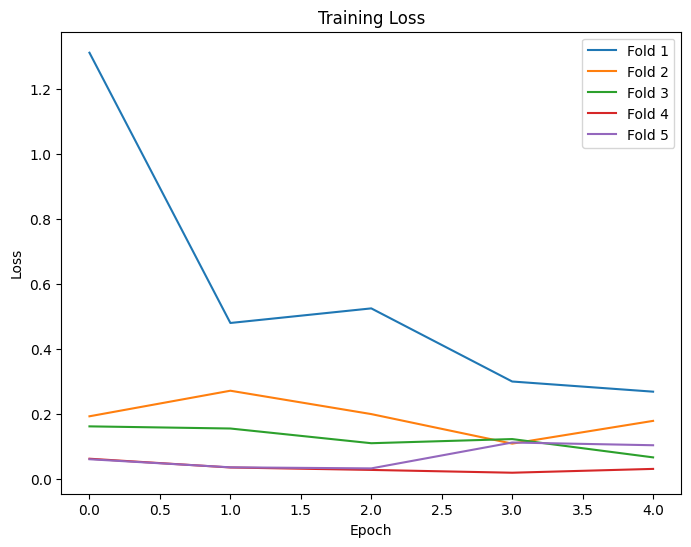

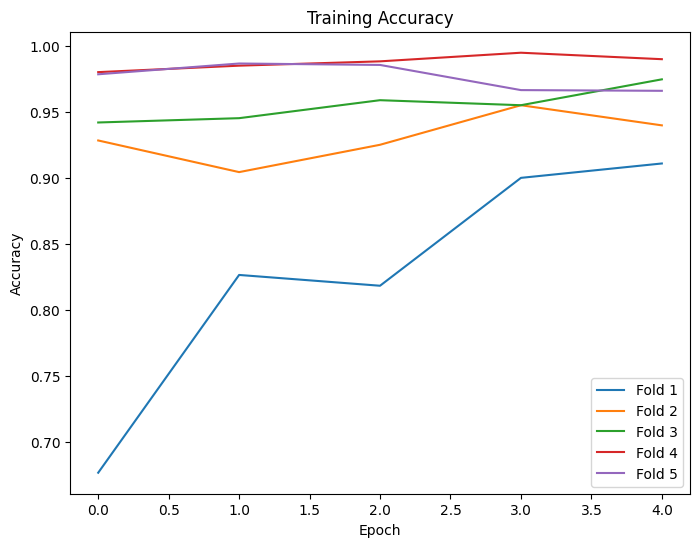

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves for all folds
plt.figure(figsize=(8,6))
for i in range(5):
    plt.plot(history_list[i].history['loss'], label='Fold {}'.format(i+1))
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves for all folds
plt.figure(figsize=(8,6))
for i in range(5):
    plt.plot(history_list[i].history['accuracy'], label='Fold {}'.format(i+1))
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

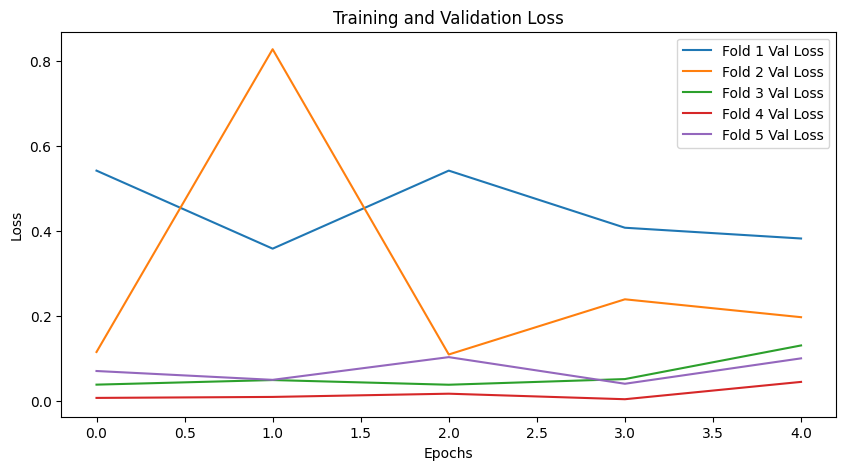

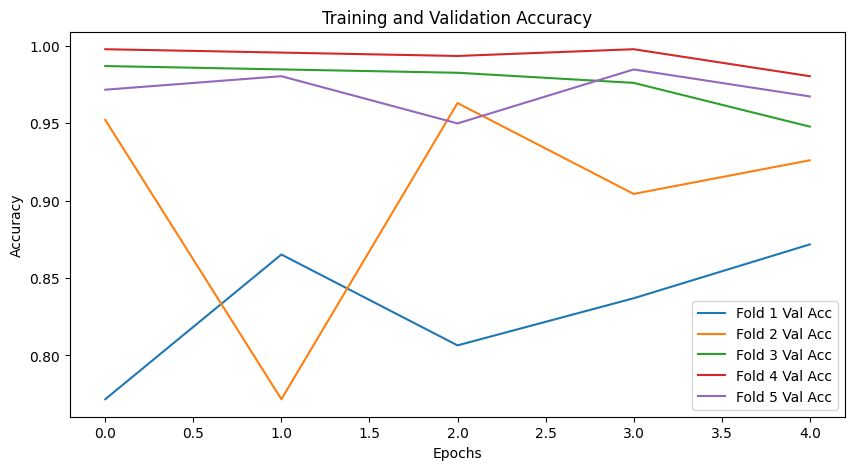

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
for i in range(5):
    plt.plot(history_list[i].history['val_loss'], label='Fold {} Val Loss'.format(i+1))
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
for i in range(5):
    plt.plot(history_list[i].history['val_accuracy'], label='Fold {} Val Acc'.format(i+1))
plt.legend()
plt.show()


In [ ]:
import pickle

with open('history_list.pkl', 'wb') as f:
    pickle.dump(history_list, f)

In [ ]:
scores= model_final.evaluate(x=x_test,y=y_test)

24/24 [==============================] - 40s 2s/step - loss: 0.6865 - accuracy: 0.8956


In [ ]:
print("%s: %.2f%%" % (model_final.metrics_names[1], scores[1]*100))

accuracy: 89.56%


In [ ]:
print(model_final.metrics_names)

['loss', 'accuracy']


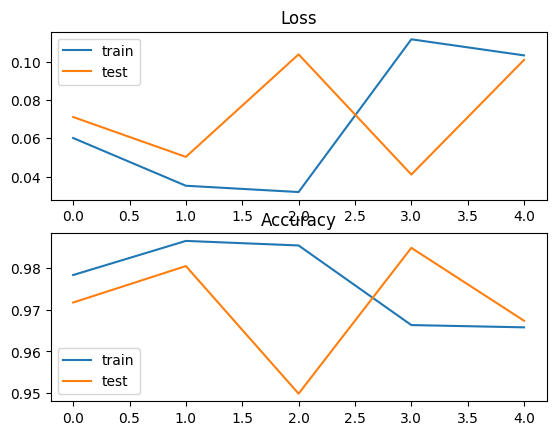

In [ ]:
from matplotlib import pyplot
# plot loss
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
yhat_classes = model_final.predict(x_test, verbose=0)

In [ ]:
y_predclasses=np.argmax(yhat_classes,axis=1)

In [ ]:
y_actual=np.argmax(y_test,axis=1)

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_predclasses, y_actual, target_names=target_names))


              precision    recall  f1-score   support

     class 0       0.84      0.83      0.83       200
     class 1       0.86      0.95      0.91       301
     class 2       0.99      0.88      0.93       265

    accuracy                           0.90       766
   macro avg       0.90      0.89      0.89       766
weighted avg       0.90      0.90      0.90       766



[[166  12  20]
 [ 34 286  11]
 [  0   3 234]]


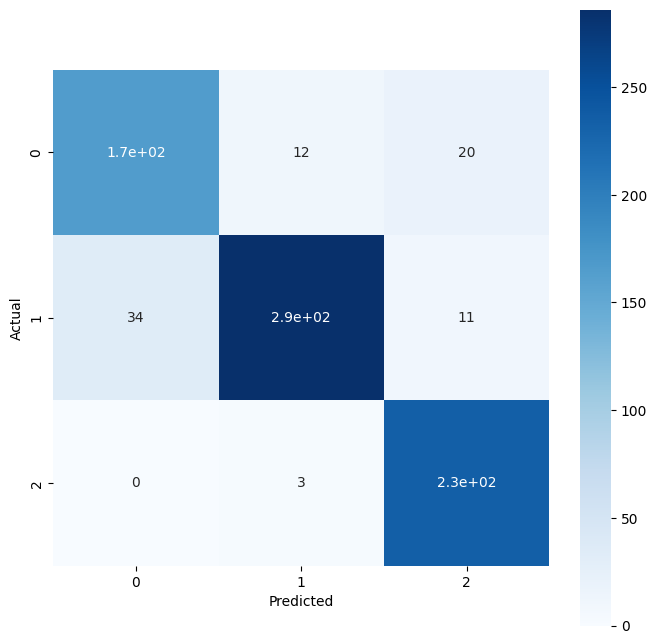

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_actual, y_predclasses)

print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, square=True, xticklabels=np.unique(y_actual), yticklabels=np.unique(y_actual))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Preprocessing

In [ ]:
history = model_final.fit( x_train, y_train, batch_size=50,epochs=5,validation_data=(x_test,y_test))

Epoch 1/5


2023-05-05 01:32:42.423055: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1807220736 exceeds 10% of free system memory.


46/46 [==============================] - 192s 4s/step - loss: 0.2427 - accuracy: 0.9508 - val_loss: 0.4730 - val_accuracy: 0.9034
Epoch 2/5
46/46 [==============================] - 184s 4s/step - loss: 0.0832 - accuracy: 0.9735 - val_loss: 0.3689 - val_accuracy: 0.9347
Epoch 3/5
46/46 [==============================] - 183s 4s/step - loss: 0.0642 - accuracy: 0.9804 - val_loss: 0.5304 - val_accuracy: 0.9073
Epoch 4/5
46/46 [==============================] - 184s 4s/step - loss: 0.0193 - accuracy: 0.9939 - val_loss: 0.3528 - val_accuracy: 0.9308
Epoch 5/5
46/46 [==============================] - 184s 4s/step - loss: 0.0085 - accuracy: 0.9983 - val_loss: 0.3409 - val_accuracy: 0.9360


In [ ]:
scores= model_final.evaluate(x=x_test,y=y_test)

24/24 [==============================] - 42s 2s/step - loss: 0.3409 - accuracy: 0.9360


In [ ]:
print("%s: %.2f%%" % (model_final.metrics_names[1], scores[1]*100))

accuracy: 93.60%


In [ ]:
yhat_classes = model_final.predict(x_test, verbose=0)

In [ ]:
y_predclasses=np.argmax(yhat_classes,axis=1)

In [ ]:
y_actual=np.argmax(y_test,axis=1)

In [ ]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_predclasses, y_actual, target_names=target_names))


              precision    recall  f1-score   support

     class 0       0.85      0.91      0.88       185
     class 1       0.95      0.92      0.93       339
     class 2       0.99      0.97      0.98       242

    accuracy                           0.94       766
   macro avg       0.93      0.94      0.93       766
weighted avg       0.94      0.94      0.94       766

